In [151]:
# http://krasserm.github.io/2018/03/19/gaussian-processes/

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [146]:
def plot_gp(mu, cov, X, samples=[]):
    X = X.reshape(-1)
    mu = mu.reshape(-1)
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label='sample_{}'.format(i))

    plt.legend()

In [124]:
def gaussian_rbf(x1, x2, l=1, sigma_f=1):
    dist_matrix = np.sum(np.square(x1), axis=1).reshape(-1, 1) + np.sum(np.square(x2), axis=1) - 2 * np.dot(x1, x2.T)
    return np.square(sigma_f) * np.exp(-1 / (2 * np.square(l)) * dist_matrix)

In [125]:
kernel = gaussian_rbf

In [126]:
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

In [127]:
mu = np.zeros(X.shape)
cov = kernel(X, X)
samples = np.random.multivariate_normal(mu.reshape(-1), cov, 3)

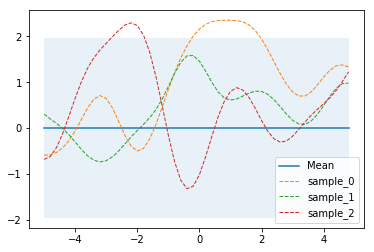

In [128]:
plot_gp(mu, cov, X, samples)

In [131]:
def posterior_predictive(X, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = kernel(X_train, X_train, l, sigma_f) + np.square(sigma_y) * np.eye(len(X_train))
    K_s = kernel(X_train, X, l, sigma_f)
    K_ss = kernel(X, X, l, sigma_f)
    
    K_inv = np.linalg.inv(K)
    
    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

In [132]:
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

mu_s, cov_s = posterior_predictive(X, X_train, Y_train)
samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)

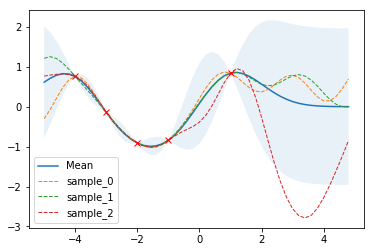

In [136]:
plot_gp(mu_s, cov_s, X, samples)
plt.plot(X_train, Y_train, 'rx')

In [143]:
noise = 0.3
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)
samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 3)

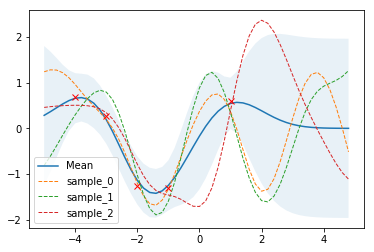

In [144]:
plot_gp(mu_s, cov_s, X, samples)
plt.plot(X_train, Y_train, 'rx')

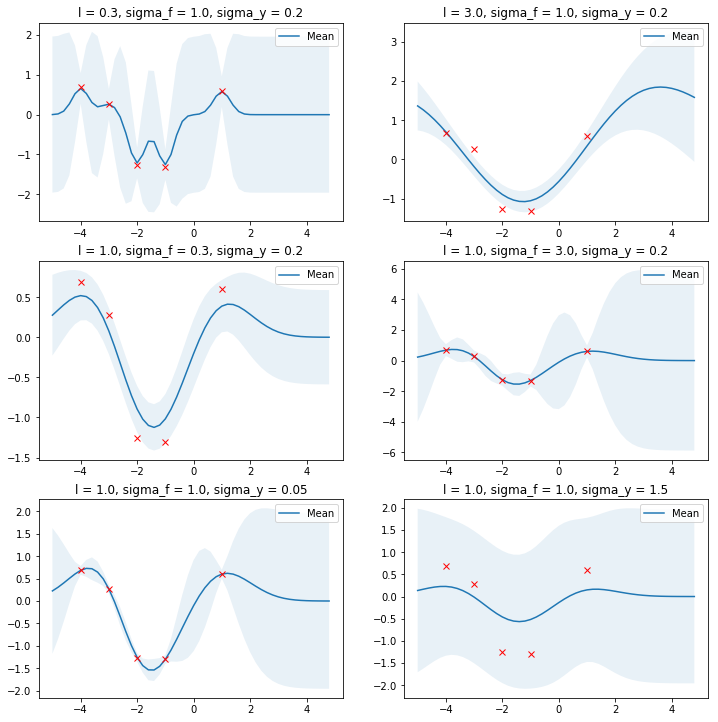

In [147]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X)
    plt.plot(X_train, Y_train, 'rx')

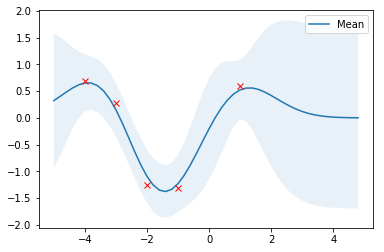

In [150]:
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise):
    def step(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return np.sum(np.log(np.diagonal(np.linalg.cholesky(K)))) + \
               0.5 * Y_train.T @ np.linalg.inv(K) @ Y_train + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step

res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X)
plt.plot(X_train, Y_train, 'rx')